# 1 環境とエージェント

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1)

In [2]:
from torch import nn
from torch import optim
import torch
import numpy as np
torch.manual_seed(1)

In [3]:
class Environment:
    
    def __init__(self, size=3, lucky=[]):
        
        self.size = size
        self.lucky = lucky
        self.goal = (size-1, size-1)
        self.states = [(x, y) for x in range(size) for y in range(size)]
            
    def next_state(self, s, a):
        
        s_next = (s[0] + a[0], s[1] + a[1])
        
        if s == self.goal:
            return s
        
        if s_next not in self.states:
            return s
        
        if s_next in self.lucky:
            if np.random.random() < 0.8:
                return self.goal
            else:
                return s_next
        
        return s_next
    
    def reward(self, s, s_next):
        
        if s == self.goal:
            return -1
        
        if s_next == self.goal:
            return 0
        
        return -1

In [4]:
class Agent():
    
    def __init__(self, environment):
        
        self.actions = [(-1, 0), (0, -1), (1, 0), (0, 1)]
        self.environment = environment
                
    def action(self, s, a, prob=False):

        s_next = self.environment.next_state(s, a)
        r = self.environment.reward(s, s_next)

        return r, s_next

# 2 DQN

In [5]:
class NN:
    def __init__(self, agent):
        self.model = self.model()
        self.criterion = nn.MSELoss()
        self.actions = agent.actions
        
    def model(self):
        model = nn.Sequential()
        model.add_module('fc1', nn.Linear(4,  16))
        model.add_module('relu1', nn.ReLU())
        model.add_module('fc2', nn.Linear(16, 8))
        model.add_module('relu1', nn.ReLU())
        model.add_module('fc3', nn.Linear(8, 1))
        self.optimizer = optim.Adam(model.parameters())
        return model
    
    def train_model(self, sa, labels, num_train=1000):
        for _ in range(num_train):
            qvalue = self.model(torch.tensor(sa).float())
            loss = self.criterion(qvalue, torch.tensor(labels).float())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def q_max(self, state):
        sa = []
        for action in self.actions:
            sa.append(state+action)
        q = self.model(torch.tensor([np.array(sa)]).float()).detach()
        a_max = np.argmax(q)
        return self.actions[a_max], q[0,a_max,0]

In [6]:
def get_episode(agent, nn_model, epsilon=0.1):
    
    s = agent.environment.states[np.random.randint(agent.environment.size**2-1)]
    
    episode = []
    while True:
        
        if np.random.random() < epsilon:
            a = agent.actions[np.random.randint(2,4)]
        else:
            a, _ = nn_model.q_max(s)
            
        r, s_next = agent.action(s, a)
        
        episode.append((s, a, r, s_next))        
        if s_next == agent.environment.goal:
            break
        s = s_next
        
    return episode

In [7]:
def train(agent, nn_model, epsilon=0.1, num=100, num_train=1000):
    for c in range(num):
        print(f'num : {c+1} ')
        
        examples = []
        for _ in range(100):
            episode = get_episode(agent, nn_model, epsilon)
            examples += episode
        np.random.shuffle(examples)
        
        sa = []
        labels = []
        for s, a, r, s_next in examples:
            sa.append(s+a)
            _, q_next = nn_model.q_max(s_next)
            labels.append([r + q_next.detach()])
            
        nn_model.train_model(sa, labels, num_train)
    
    show_values(agent, model1)
    show_policy(agent, model1)

# 3 可視化用関数

In [8]:
def show_maze(environment):
    size = environment.size
    fig = plt.figure(figsize=(3,3))

    plt.plot([-0.5, -0.5], [-0.5, size-0.5], color='k')
    plt.plot([-0.5, size-0.5], [size-0.5, size-0.5], color='k')
    plt.plot([size-0.5, -0.5], [-0.5, -0.5], color='k')
    plt.plot([size-0.5, size-0.5], [size-0.5, -0.5], color='k')
    
    for i in range(size):
        for j in range(size):
            plt.text(i, j, "{}".format(i+size*j), size=20, ha="center", va="center")
            if (i,j) in environment.lucky:
                x = np.array([i-0.5,i-0.5,i+0.5,i+0.5])
                y = np.array([j-0.5,j+0.5,j+0.5,j-0.5])
                plt.fill(x,y, color="lightgreen")

    plt.axis("off")

In [9]:
def show_values(agent, nn_model):

    fig = plt.figure(figsize=(3,3))
    result = np.zeros([agent.environment.size, agent.environment.size])
    for (x, y) in agent.environment.states:
        a_max, q_max =  nn_model.q_max((x, y))
        result[y][x]  = q_max
        
    sns.heatmap(result, square=True, cbar=False, annot=True, fmt='3.2f', cmap='autumn_r').invert_yaxis()
    plt.axis("off")

In [10]:
 def show_policy(agent, nn_model):
    size = agent.environment.size
    fig = plt.figure(figsize=(3,3))

    plt.plot([-0.5, -0.5], [-0.5, size-0.5], color='k')
    plt.plot([-0.5, size-0.5], [size-0.5, size-0.5], color='k')
    plt.plot([size-0.5, -0.5], [-0.5, -0.5], color='k')
    plt.plot([size-0.5, size-0.5], [size-0.5, -0.5], color='k')

    for i in range(size):
        for j in range(size):
            if (i,j) in agent.environment.lucky:
                x = np.array([i-0.5,i-0.5,i+0.5,i+0.5])
                y = np.array([j-0.5,j+0.5,j+0.5,j-0.5])
                plt.fill(x,y, color="lightgreen")

    rotation = {(-1, 0): 180, (0, 1): 90, (1, 0): 0, (0, -1): 270}
    for s in agent.environment.states:
        if s == agent.environment.goal:
            direction=None
        else:
            a_max, q_max =  nn_model.q_max(s)
            direction = rotation[a_max]
        
        if direction != None:
            bbox_props = dict(boxstyle='rarrow')
            plt.text(s[0], s[1], '     ', bbox=bbox_props, size=8,
                     ha='center', va='center', rotation=direction)
                        
    plt.axis("off")

# 4 シミュレーション

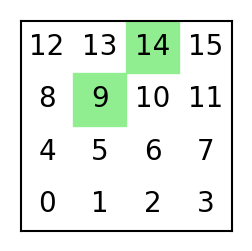

In [11]:
env1 = Environment(size=4, lucky=[(1,2),(2,3)])
agent1 = Agent(env1)
model1 = NN(agent1)
show_maze(env1)

num : 1 


/tmp/ipykernel_33277/2785268152.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  q = self.model(torch.tensor([np.array(sa)]).float()).detach()


num : 2 
num : 3 
num : 4 
num : 5 


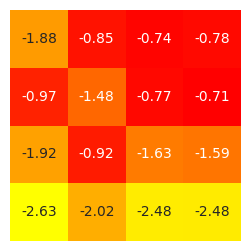

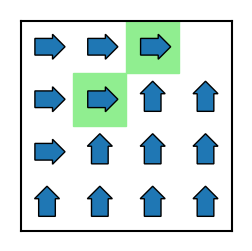

In [12]:
train(agent1, model1, epsilon=0.5, num=5)